In [2]:
import pandas as pd
import anndata
import ast
pd.options.mode.copy_on_write = True

In [24]:
# Read data
dat = pd.read_csv('data/raw_reformatted.csv', index_col=0)

# Make small dataset for testing
dat = dat.loc[(dat['pert_time'] == 24) | (dat['pert_time'] == 0)]
dat = dat.loc[(dat['protein_plate'] == 'MCF7') | (dat['protein_plate'] == 'T47D')]

# Separate meta and protein data
dat_proteins = dat.loc[:, dat.columns.str.contains('HUMAN')]
dat_meta = dat.loc[:, ~dat.columns.str.contains('HUMAN')]

# Filter pert_time = 24h
dat_meta.drop(columns=["pert_time"], inplace=True)

/tmp/ipykernel_9869/2790070115.py:2: DtypeWarning: Columns (0,5528) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('data/raw_reformatted.csv', index_col=0)


In [3]:
# Create AnnData object
# adata = anndata.AnnData(X=dat_proteins.values, obs=dat_meta)
# adata.write("data/preprocessed_small.h5ad")

# Read AnnData object
adata = anndata.read("data/preprocessed_small.h5ad")

/home/mike/Masters_DS/master_thesis/.venv/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
adata.obs

,protein_plate,machine,bio_rep,anchor_dose,library_dose,type,IC50,NY,anchor_drug,library_drug,n_genes
Sample_ID,,,,,,,,,,,
D4291,MCF7,WAE,1.0,0.50,0.0125,drugCombination,8.213310,NaN,#33,#53,2550
D4171,MCF7,D,2.0,0.50,0.0125,drugCombination,8.213310,NaN,#33,#53,1981
D4411,MCF7,WAE,3.0,0.50,0.0125,drugCombination,8.213310,NaN,#33,#53,1940
D4365,MCF7,D,1.0,0.01,30.0000,drugCombination,15.341700,NaN,#47,#56,1504
D4245,MCF7,D,2.0,0.01,30.0000,drugCombination,15.341700,NaN,#47,#56,1763
...,...,...,...,...,...,...,...,...,...,...,...
B37,T47D,WAF,1.0,10.00,0.0000,singleDrug,5.561325,N,#18,no,2359
B2160,T47D,WAF,2.0,10.00,0.0000,singleDrug,5.403574,Y,#64,no,1644
B162,T47D,WAF,1.0,10.00,0.0000,singleDrug,5.403574,Y,#64,no,964


In [34]:
import scanpy as sc

# -----------------------------
# 1. Load and Filter the Data
# -----------------------------
# Replace the file path with your AnnData file
adata = sc.read_h5ad("data/preprocessed_small.h5ad") #730 × 5519

# Before 730 × 5519

# Example filtering: remove cells with low gene/protein counts and features detected in very few cells
sc.pp.filter_cells(adata, min_genes=100)   # adjust threshold as appropriate for your data
sc.pp.filter_genes(adata, min_cells=5)       # adjust threshold as appropriate

# After 715 × 4611

# Normalization and log scale
#sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

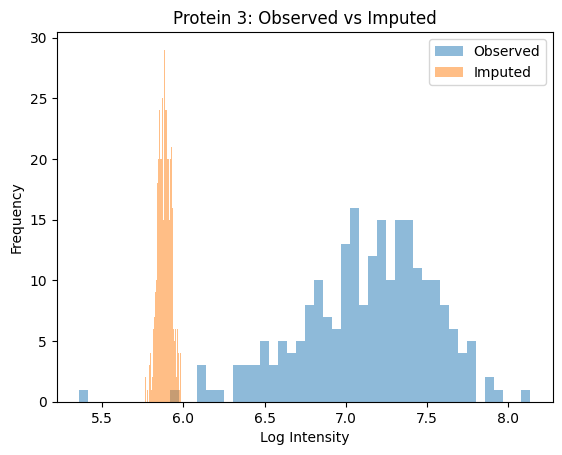

In [35]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

# Ensure data is in dense format if needed.
if hasattr(adata.X, "toarray"):
    data = adata.X.toarray().copy()
else:
    data = adata.X.copy()

# Create a copy for the imputed data.
data_imputed = data.copy()

# Iterate over each protein (column)
for i in range(data.shape[1]):
    col = data[:, i]
    missing = np.isnan(col)
    observed = col[~missing]
    
    # Only perform imputation if there are observed values.
    if len(observed) > 0:
        mean_obs = np.mean(observed)
        # get 1st percentile
        perc1_obs = np.percentile(observed, 1)
        std_obs = np.std(observed)
        
        # Define per-protein imputation parameters:
        impute_mean = perc1_obs - 0.5 * std_obs
        impute_std = 0.1 * std_obs
        
        # Generate imputed values for missing entries.
        imputed_values = np.random.normal(impute_mean, impute_std, size=missing.sum())
        data_imputed[missing, i] = imputed_values
    else:
        # Optionally, handle columns where all values are missing.
        # For now, we'll leave them as NaN.
        data_imputed[:, i] = np.nan

# Save the imputed data in a new layer of the AnnData object.
adata.X = data_imputed

# -----------------------------
# Visualization Example
# -----------------------------
# Let's visualize for one protein (e.g., the first protein)
protein_index = 3  # adjust as needed
observed_vals = data[:, protein_index][~np.isnan(data[:, protein_index])]
imputed_vals = data_imputed[:, protein_index][np.isnan(data[:, protein_index])]

plt.hist(observed_vals, bins=50, alpha=0.5, label="Observed")
plt.hist(imputed_vals, bins=50, alpha=0.5, label="Imputed")
plt.xlabel("Log Intensity")
plt.ylabel("Frequency")
plt.title(f"Protein {adata.var_names[protein_index]}: Observed vs Imputed")
plt.legend()
plt.show()


In [36]:
import numpy as np
import scipy.sparse as sp

sc.pp.scale(adata)

# Normalize per baseline state
# # 1. Identify "noDrug" samples in adata.obs["type"]
# no_drug_mask = adata.obs["type"] == "noDrug"

# # 2. Extract the data matrix for the noDrug subset
# no_drug_data = adata[no_drug_mask].X

# # If it's sparse, convert to a dense NumPy array
# if sp.issparse(no_drug_data):
#     no_drug_data = no_drug_data.toarray()

# # 3. Compute per-feature mean and std for noDrug samples
# means = no_drug_data.mean(axis=0)
# stds = no_drug_data.std(axis=0, ddof=1)  # ddof=1 for sample std

# # (Optional) Guard against zero std to avoid divide-by-zero
# stds[stds == 0] = 1e-9

# # 4. Apply z-score normalization to *all* samples
# data_all = adata.X
# if sp.issparse(data_all):
#     data_all = data_all.toarray()

# zscored_data = (data_all - means) / stds

# # 5. Store the z-scored values in a new layer
# adata.layers["zscored_noDrug"] = zscored_data


In [37]:
import harmonypy as hm
import scanpy as sc
import pandas as pd


# (2) Prepare metadata with relevant variables
# Here, include all metadata for inspection, but note that we only use "machine" for correction.
meta_data = adata.obs[["machine", "anchor_drug", "library_drug", "protein_plate"]]

# (3) Run Harmony with "machine" as the batch key
ho = hm.run_harmony(adata.X, meta_data, vars_use=["machine"], max_iter_harmony=20)

# The corrected embeddings are stored in ho.Z_corr (each column corresponds to a cell)
adata.layers["X_harmony"] = ho.Z_corr.T


2025-03-29 09:29:49,795 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-29 09:29:54,481 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-29 09:29:54,594 - harmonypy - INFO - Iteration 1 of 20
2025-03-29 09:29:56,188 - harmonypy - INFO - Iteration 2 of 20
2025-03-29 09:29:58,007 - harmonypy - INFO - Converged after 2 iterations


In [38]:
adata.obs[["machine","type"]].value_counts()

machine  type           
WAF      singleDrug         185
D        singleDrug         175
WAE      drugCombination    122
D        drugCombination     85
         noDrug              64
WAF      noDrug              64
WAE      noDrug              20
Name: count, dtype: int64

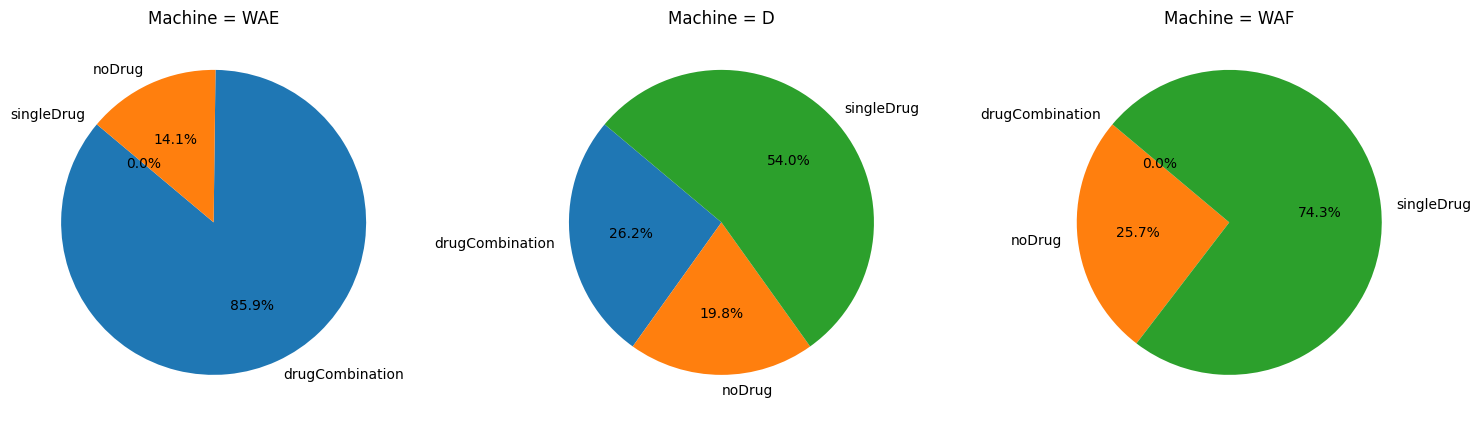

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify all unique machines and types
machines = adata.obs["machine"].unique()
types = adata.obs["type"].unique()
n_machines = len(machines)

# 2. Create a color mapping for each type so colors remain consistent
palette = sns.color_palette("tab10", n_colors=len(types))  # or choose another palette
type_colors = dict(zip(types, palette))

# 3. Prepare the figure with one subplot per machine
fig, axes = plt.subplots(1, n_machines, figsize=(5 * n_machines, 5), subplot_kw=dict(aspect="equal"))

# 4. Generate one pie chart per machine
for i, machine in enumerate(machines):
    ax = axes[i] if n_machines > 1 else axes
    
    # Filter to rows belonging to the current machine
    mask = adata.obs["machine"] == machine
    
    # Get counts of each type within this machine
    counts = adata.obs.loc[mask, "type"].value_counts()
    
    # Reindex to ensure all types are present in the same order (missing become zero)
    counts = counts.reindex(types, fill_value=0)
    
    # Prepare a list of colors in the same order as 'types'
    colors = [type_colors[t] for t in counts.index]
    
    # Plot the pie chart
    ax.pie(counts.values, labels=counts.index, colors=colors, autopct="%1.1f%%", startangle=140)
    ax.set_title(f"Machine = {machine}")

plt.tight_layout()
plt.show()




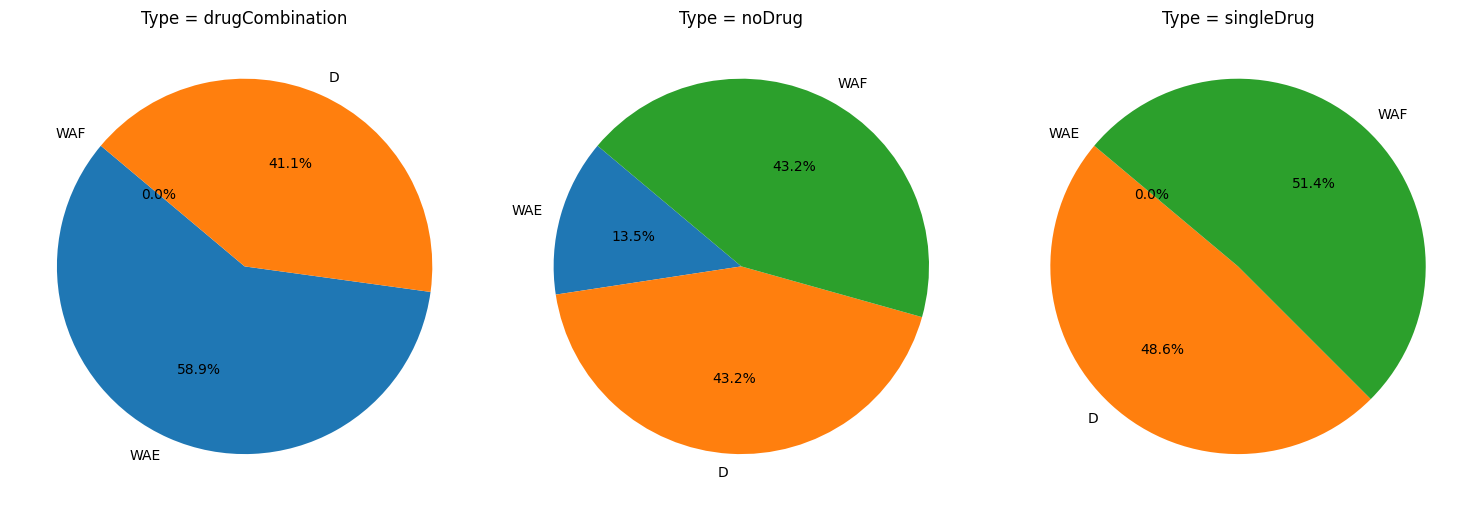

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify all unique types and machines
types = adata.obs["type"].unique()
machines = adata.obs["machine"].unique()
n_types = len(types)

# 2. Create a consistent color mapping for each machine
palette = sns.color_palette("tab10", n_colors=len(machines))  # adjust palette if desired
machine_colors = dict(zip(machines, palette))

# 3. Create subplots: one pie chart per type
fig, axes = plt.subplots(1, n_types, figsize=(5 * n_types, 5), subplot_kw=dict(aspect="equal"))

# 4. Loop over each type and plot the machine distribution with consistent colors
for i, t in enumerate(types):
    ax = axes[i] if n_types > 1 else axes
    # Filter to samples of this type
    mask = adata.obs["type"] == t
    # Count machine occurrences within this type
    counts = adata.obs.loc[mask, "machine"].value_counts()
    # Ensure every machine is present in the same order (machines with zero count become 0)
    counts = counts.reindex(machines, fill_value=0)
    # Build list of colors from our mapping in the same order as the machine categories
    colors = [machine_colors[m] for m in counts.index]
    
    # Plot the pie chart
    ax.pie(
        counts.values,
        labels=counts.index,
        colors=colors,
        autopct="%1.1f%%",
        startangle=140
    )
    ax.set_title(f"Type = {t}")

plt.tight_layout()
plt.show()


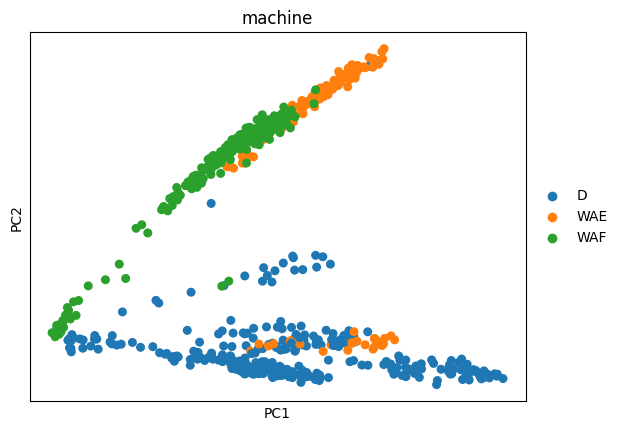

In [14]:

# (4) Optionally, visualize the result to ensure drug and cell line heterogeneity is preserved:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color=["machine"])


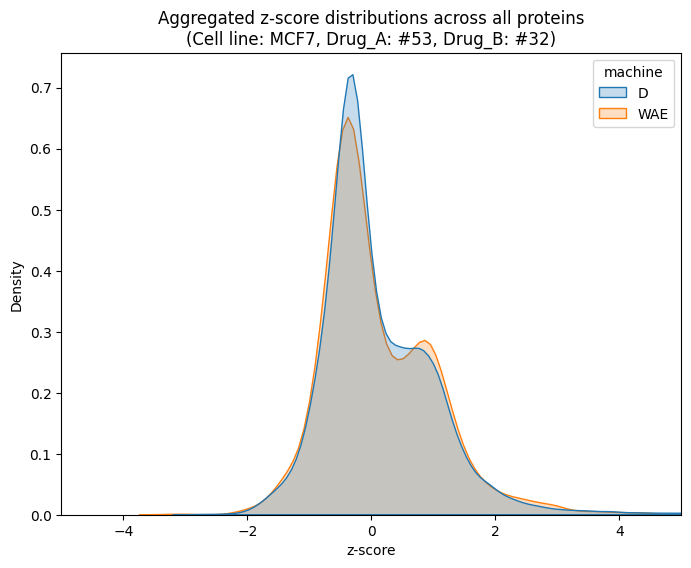

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Filter the AnnData object for the cell line and drug of interest
protein_plate = "MCF7"  # cell line identifier (adjust if needed)
drug_A = "#53"
drug_B = "#32"

adata_exp = adata[(adata.obs["protein_plate"] == protein_plate) & 
                  (adata.obs["anchor_drug"] == drug_A) & 
                  (adata.obs["library_drug"] == drug_B)].copy()

# 2. Extract the z-scored data (assumed to be stored in adata_exp.X)
zscored = adata_exp.X
if hasattr(zscored, "toarray"):
    zscored = zscored.toarray()

# 3. Create a DataFrame with samples as rows and proteins as columns
df_z = pd.DataFrame(zscored, index=adata_exp.obs_names, columns=adata_exp.var_names)

# 4. Reshape the DataFrame into long format to aggregate across all proteins
df_long = df_z.melt(var_name="Protein", value_name="zscore")
# Add the machine annotation (repeat for each protein measurement per sample)
df_long["machine"] = np.repeat(adata_exp.obs["machine"].values, df_z.shape[1])

# 5. Plot the aggregated KDE distribution with separate curves for each machine
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_long, x="zscore", hue="machine", fill=True, common_norm=False)
plt.title("Aggregated z-score distributions across all proteins\n"
          f"(Cell line: {protein_plate}, Drug_A: {drug_A}, Drug_B: {drug_B})")
plt.xlim(-5,5)
plt.xlabel("z-score")
plt.ylabel("Density")
plt.show()





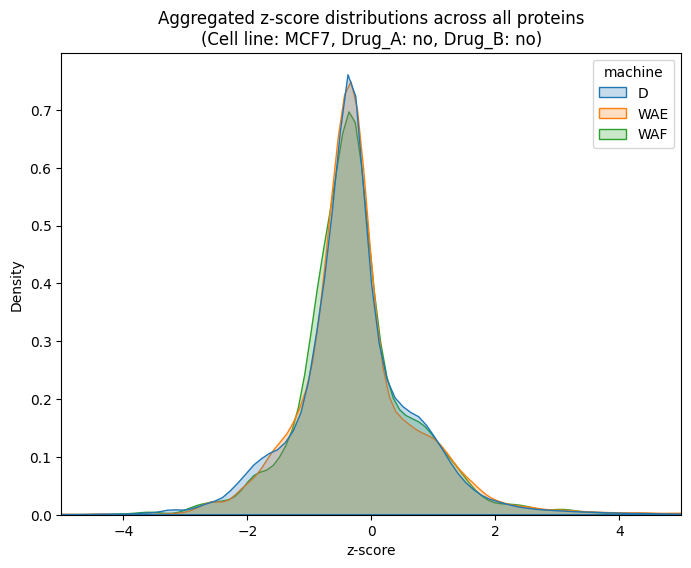

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Filter the AnnData object for the cell line and drug of interest
protein_plate = "MCF7"  # cell line identifier (adjust if needed)
drug_A = "no"
drug_B = "no"

adata_exp = adata[(adata.obs["protein_plate"] == protein_plate) & 
                  (adata.obs["anchor_drug"] == drug_A) & 
                  (adata.obs["library_drug"] == drug_B)].copy()

# 2. Extract the z-scored data (assumed to be stored in adata_exp.X)
zscored = adata_exp.layers["X_harmony"]
if hasattr(zscored, "toarray"):
    zscored = zscored.toarray()

# 3. Create a DataFrame with samples as rows and proteins as columns
df_z = pd.DataFrame(zscored, index=adata_exp.obs_names, columns=adata_exp.var_names)

# 4. Reshape the DataFrame into long format to aggregate across all proteins
df_long = df_z.melt(var_name="Protein", value_name="zscore")
# Add the machine annotation (repeat for each protein measurement per sample)
df_long["machine"] = np.repeat(adata_exp.obs["machine"].values, df_z.shape[1])

# 5. Plot the aggregated KDE distribution with separate curves for each machine
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df_long, x="zscore", hue="machine", fill=True, common_norm=False)
plt.title("Aggregated z-score distributions across all proteins\n"
          f"(Cell line: {protein_plate}, Drug_A: {drug_A}, Drug_B: {drug_B})")
plt.xlim(-5,5)
plt.xlabel("z-score")
plt.ylabel("Density")
plt.show()





In [1]:
adata.obs

NameError: name 'adata' is not defined